Andy Nguyen, Michael Wolfe, Spencer Fogelman, & Joseph Caguioa

DS 7331.407

Thursday 6:30pm - 8:00pm

# Logistic Regression and SVMs of AirBnB Data

### Instructions
[50 Points]
* Assess performance of each model using 80/20 training-test split
* Adjust model parameters to optimize accuracy
    * if dataset size requires stochastic gradient descent, then only linear kernel is appropriate
    
[10 Points]
* Discuss advantages of each model for each classification task
* Does one type of model offer superior performance over another in terms of prediction accuracy?
    * In terms of training time or efficiency? Explain.

[30 points]
* Use weights from logistic regression to interpret importance of different features for each classification task. Explain interpretation in detail.
    * Why do you think some variables are more important?
    
[10 points]
* Look at the chosen support vectors for the classifcation task. Do these provide any insight into the data? Explain.

## Introduction

*Dataset Source: https://www.kaggle.com/rudymizrahi/airbnb-listings-in-major-us-cities-deloitte-ml*

This Kaggle dataset contains data on Airbnb listings for six major U.S. cities. The competition's original goal was to use available attributes to predict listing price. However, the inherent richness of the variables also allows

Airbnb Superhosts are experienced property owners who guests have helped rate as the best of the best. Earning this designation requires obtaining a minimum number of yearly stays, maintaining a high response rate, keeping above a certain score average, and avoiding cancellations. However, is it possible to predict Superhost status off of other attributes on the listing? For simplicity we define a Superhost as someone with a score average greater than or equal to 96%.

**Setup**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
#import plotly.graph_objects as go
import datetime
import csv
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import warnings
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/anguyen-07/DS7331-ML_Labs/master/data/airbnb_train.csv')
df['grade'] = pd.cut(df.review_scores_rating, [0,60,70,80,90,101], right=False, labels = ['F', 'D', 'C', 'B', 'A'])
df.dtypes

id                           int64
log_price                  float64
property_type               object
room_type                   object
amenities                   object
accommodates                 int64
bathrooms                  float64
bed_type                    object
cancellation_policy         object
cleaning_fee                  bool
city                        object
description                 object
first_review                object
host_has_profile_pic        object
host_identity_verified      object
host_response_rate          object
host_since                  object
instant_bookable            object
last_review                 object
latitude                   float64
longitude                  float64
name                        object
neighbourhood               object
number_of_reviews            int64
review_scores_rating       float64
thumbnail_url               object
zipcode                     object
bedrooms                   float64
beds                

The first step to preparing the Airbnb dataset for use with logistic regression and support vector machines is to remove or impute missing data and change the variables to compatible datatypes. Much of the logic behind this work was covered in Lab 1.

**Cleanup (from first project)**

In [3]:
##Clean up datatypes and duplicates
df_ratings = df.dropna(subset=['review_scores_rating'])
floats = ['log_price','bathrooms','latitude','longitude','review_scores_rating']
df_ratings[floats] = df_ratings[floats].astype(np.float64)
ints = ['id','accommodates','number_of_reviews','bedrooms','beds']
df_ratings["host_response_rate"] = df_ratings["host_response_rate"].str.rstrip('%').astype(np.float64)/100
date_time = ['first_review','host_since','last_review']
df_ratings[date_time] = df_ratings[date_time].apply(pd.to_datetime)
booleans = ['host_has_profile_pic','host_identity_verified','instant_bookable']
df_ratings[booleans] = df_ratings[booleans].replace({'t':True,'f':False})
df_ratings[booleans] = df_ratings[booleans].astype(np.bool)
categorical = ['property_type','room_type','bed_type','cancellation_policy','city','neighbourhood','zipcode']
df_ratings[categorical] = df_ratings[categorical].astype('category')
df_ratings.drop_duplicates()
df_ratings.host_since[df_ratings.host_since.isna()] = df_ratings.first_review[df_ratings.host_since.isna()]

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import

In [4]:
# Impute missing values
df_imputed = df_ratings
df_imputed["bathrooms"] = df_imputed["bathrooms"].fillna(df_imputed.groupby(["property_type","accommodates"])["bathrooms"].apply(lambda x : x.fillna(x.median())))
df_imputed["bedrooms"] = df_imputed["bedrooms"].fillna(df_imputed.groupby(["property_type","accommodates"])["bedrooms"].apply(lambda x : x.fillna(x.median())))
df_imputed["beds"] = df_imputed["beds"].fillna(df_imputed.groupby(["property_type","accommodates"])["beds"].apply(lambda x : x.fillna(x.median())))
df_imputed["host_response_rate"] = df_imputed["host_response_rate"].fillna(df_imputed.groupby(["number_of_reviews"])["host_response_rate"].apply(lambda x : x.fillna(x.mean())))
# Impute Missing Value of for 100% Host Response Rate for Row 48194 - Private Room in Apartment
df_imputed["host_response_rate"][df_imputed["host_response_rate"].isna()] = 1.0
df_imputed[ints] = df_imputed[ints].astype(np.int64)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

Additionally, some of the existing attributes can be transformed into a potentially more useful datatype.

In [5]:
df_imputed['price'] = np.exp(df_imputed['log_price'])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [6]:
import re
#Create a new cleaned amenities column where all amenities are in list form
df_imputed['amenities_new'] = df_imputed.apply(lambda row: re.sub(r'[{}""]', '', row['amenities']), axis=1)
df_imputed['amenities_new'] = df_imputed.apply(lambda row: row['amenities_new'].lower().split(','), axis=1)
df_imputed = df_imputed.reset_index()
df_imputed['length_amenities'] = df_imputed.apply(lambda row: len(row['amenities_new']), axis=1)

# Create separate columns based on amenities
df_imputed['internet'] = df_imputed.apply(lambda row: 'internet' in row.amenities.lower(), axis=1)
df_imputed['TV'] = df_imputed.apply(lambda row: 'tv' in row.amenities.lower(), axis=1)
df_imputed['air_conditioning'] = df_imputed.apply(lambda row: 'air conditioning' in row.amenities.lower(), axis=1)
df_imputed['kitchen'] = df_imputed.apply(lambda row: 'kitchen' in row.amenities.lower(), axis=1)
df_imputed['pool'] = df_imputed.apply(lambda row: 'pool' in row.amenities.lower(), axis=1)
df_imputed['parking'] = df_imputed.apply(lambda row: 'parking' in row.amenities.lower(), axis=1)

# Get information from description based on length in characters
df_imputed['description_length'] = df_imputed['description'].apply(len)

# Create the target variable superuser
df_imputed['superuser'] = False
df_imputed.loc[df.review_scores_rating >=96, 'superuser'] = True

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [7]:
import datetime
date_published = datetime.datetime(2018,3,14)
df_imputed['host_since'] = pd.to_datetime(df_imputed['host_since'])
df_imputed['host_since_days'] = df_imputed.apply(lambda row: (date_published - row['host_since']).days, axis=1)

Columns that are not meaningful in a modeling context (e.g., index, id), redundant with newly engineered features (e.g., amenities, description), or likely not useful in predicting the target variable superuser (e.g., zipcode, thumbnail_url) are removed. 

In [8]:
# delete useless columns
df_logistic = df_imputed.drop(['index', 'id', 'log_price', 'amenities', 'description', 'zipcode', 'description',
                      'latitude', 'longitude', 'name', 'neighbourhood', 'review_scores_rating',
                      'thumbnail_url', 'zipcode'], axis=1)

# Delete other redundant variables
del df_logistic['amenities_new']
del df_logistic['host_since']
del df_logistic['grade']
del df_logistic['first_review']
del df_logistic['last_review']

In [9]:
categorical_vars = ['property_type', 'room_type', 'bed_type', 'cancellation_policy', 'city']
df_logistic[categorical_vars].apply(lambda x: len(x.value_counts()), axis=0)

property_type          32
room_type               3
bed_type                5
cancellation_policy     5
city                    6
dtype: int64

In [10]:
# Remove factor with unnecessarily large number of levels
df_logistic.drop(['property_type'], axis=1, inplace=True)

In [11]:
df_logistic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57389 entries, 0 to 57388
Data columns (total 25 columns):
room_type                 57389 non-null category
accommodates              57389 non-null int64
bathrooms                 57389 non-null float64
bed_type                  57389 non-null category
cancellation_policy       57389 non-null category
cleaning_fee              57389 non-null bool
city                      57389 non-null category
host_has_profile_pic      57389 non-null bool
host_identity_verified    57389 non-null bool
host_response_rate        57389 non-null float64
instant_bookable          57389 non-null bool
number_of_reviews         57389 non-null int64
bedrooms                  57389 non-null int64
beds                      57389 non-null int64
price                     57389 non-null float64
length_amenities          57389 non-null int64
internet                  57389 non-null bool
TV                        57389 non-null bool
air_conditioning          57389 n

#### Checking Class Imbalances & Collinearity

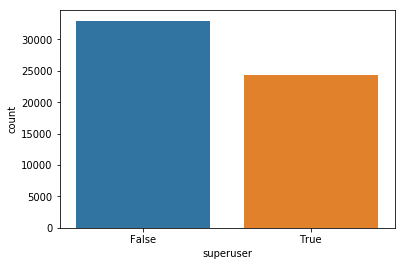

In [12]:
sns.countplot(data=df_logistic, x='superuser')

A simple bar chart of the counts shows that both classes of Superuser, the target variable, are well-represented in the remaining data.

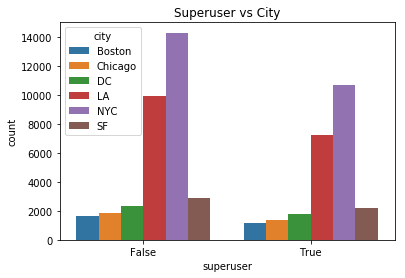

In [13]:
sns.countplot(data=df_logistic, x='superuser', hue='city')
plt.title('Superuser vs City')
plt.show()

One of the multi-level categorical variables retained in building the models, city, doesn't appear to have major imbalances when accounting for Superuser status. It is worth noting that New York City and Los Angeles are more strongly represented than the other four.

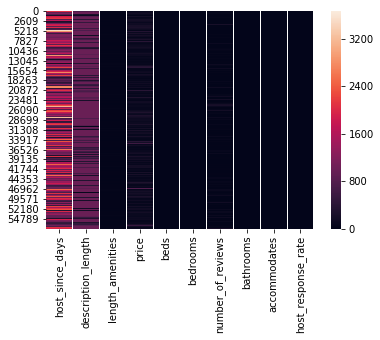

In [14]:
numerical_features = ['host_since_days', 'description_length', 'length_amenities', 'price', 'beds',
                     'bedrooms', 'number_of_reviews', 'bathrooms', 'accommodates', 'host_response_rate']
sns.heatmap(df_logistic[numerical_features])

Collinearity does not appear to be a concern based on the numeric variables. However, it is worth noting that there are vast scaling differences. For example, host_since_days counts the number of days a listing existed until a given date, resulting in a mean in the thousands because many listings have been active for several years. In contrast, host_response_rate is a percentage. Standardizing these values to account for this may be useful, and is explored later on.

In [15]:
# Create dummy variables
categorical_vars = ['parking', 'pool', 'kitchen', 'air_conditioning', 'TV', 'internet', 'instant_bookable',
                   'host_identity_verified', 'host_has_profile_pic', 'city', 'cleaning_fee', 'cancellation_policy',
                   'bed_type', 'room_type']
dummy_df = pd.get_dummies(df_logistic[categorical_vars], drop_first=True)
df_logistic_dummy = pd.concat([df_logistic, dummy_df], axis=1)

# Delete non-dummy categorical variables
for x in categorical_vars:
    if x in df_logistic_dummy:
        del df_logistic_dummy[x]

df_logistic_dummy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57389 entries, 0 to 57388
Data columns (total 26 columns):
accommodates                           57389 non-null int64
bathrooms                              57389 non-null float64
host_response_rate                     57389 non-null float64
number_of_reviews                      57389 non-null int64
bedrooms                               57389 non-null int64
beds                                   57389 non-null int64
price                                  57389 non-null float64
length_amenities                       57389 non-null int64
description_length                     57389 non-null int64
superuser                              57389 non-null bool
host_since_days                        57389 non-null int64
city_Chicago                           57389 non-null uint8
city_DC                                57389 non-null uint8
city_LA                                57389 non-null uint8
city_NYC                               57389 n

### Training/Test Data Split

In [16]:
y = df_logistic_dummy['superuser'].values
X = df_logistic_dummy.drop(['superuser'], axis=1).values

In [17]:
from sklearn.model_selection import ShuffleSplit
# Use X to predict the binary class of y
## X and Y are numpy matricies - .values call converts the data type to simple matrices
if 'superuser' in df_logistic_dummy:
    y = df_logistic_dummy['superuser'].values # retrieve binary value for class distinction
    del df_logistic_dummy['superuser'] # get rid of True/False label
    X = df_logistic_dummy.values # use all other attribute values to predict
    
num_cv_iterations = 10
num_instances = len(y)
cv_object = ShuffleSplit(n_splits = num_cv_iterations,
                        test_size = 0.2,
                        random_state = 123) # set random number seed
cv_object

ShuffleSplit(n_splits=10, random_state=123, test_size=0.2, train_size=None)

## Create Models

### Logistic Regression Model

#### Without Scaling

In [18]:
##Basic model, all numeric data
#x_train, x_test, y_train, y_test = train_test_split(df_imputed.loc[:,['log_price','accommodates','bathrooms','number_of_reviews','review_scores_rating','bedrooms','beds']]
#                                                    , df_imputed.loc[:,['grade']], test_size=0.2, random_state=0)
#LogisticRegression().fit(x_train,y_train).predict(x_test[0].reshape(1,-1))


In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit

#create logistic regression object
lr_clf = LogisticRegression(penalty='l2', C=1.0, class_weight=None, solver='liblinear' ) # get object


In [20]:
accuracies = cross_val_score(lr_clf, X, y=y, cv=cv_object) # this also can help with parallelism
accuracies

array([0.57727827, 0.56961143, 0.57727827, 0.57022129, 0.57257362,
       0.57074403, 0.57091828, 0.57631992, 0.57152814, 0.57501307])

#### With Scaling

In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import metrics as mt
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import statistics

In [22]:
std_scl = StandardScaler()
lr_clf = LogisticRegression(penalty='l2', C=0.05, solver='liblinear') 

# create the pipline
piped_object = Pipeline([('scale', std_scl),  # do this
                         ('logit_model', lr_clf)]) # and then do this
#Pipeline takes in a list of tuples, where each tuple is (object name, object)

In [23]:
weights = []
accuracy_average = []
recall_average = []
precision_average = []
f1_average = []
# run the pipline cross validated
for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X,y)):
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    piped_object.fit(X_train, y_train)  # train object
    # it is a little odd getting trained objects from a  pipeline:
    weights.append(piped_object.named_steps['logit_model'].coef_[0])
    
    y_hat = piped_object.predict(X_test)
    acc_iter = mt.accuracy_score(y_test, y_hat)
    rec_iter = mt.recall_score(y_test, y_hat)
    pre_iter = mt.precision_score(y_test, y_hat)
    f1_iter = mt.f1_score(y_test, y_hat)
    conf_iter = mt.confusion_matrix(y_test, y_hat)
    
    accuracy_average.append(acc_iter)
    recall_average.append(rec_iter)
    precision_average.append(pre_iter)
    f1_average.append(f1_iter)
    
    print("#### Iteration", iter_num, "####")
    print("accuracy:", acc_iter)
    print("recall:", rec_iter)
    print("precision:", pre_iter)
    print("f1 score:", f1_iter)
    print("confusion matrix:\n", conf_iter)

weights = np.array(weights)
print("#### 10-Fold Averages ####")
print("average accuracy:", statistics.mean(accuracy_average))
print("average recall:", statistics.mean(recall_average))
print("average precision:", statistics.mean(precision_average))
print("average f1 score:", statistics.mean(f1_average))

#### Iteration 0 ####
accuracy: 0.5775396410524481
recall: 0.00247320692497939
precision: 0.5714285714285714
f1 score: 0.004925097475887543
confusion matrix:
 [[6617    9]
 [4840   12]]
#### Iteration 1 ####
accuracy: 0.5695243073706221
recall: 0.002631578947368421
precision: 0.48148148148148145
f1 score: 0.0052345480169116165
confusion matrix:
 [[6524   14]
 [4927   13]]
#### Iteration 2 ####
accuracy: 0.5775396410524481
recall: 0.003503709810387469
precision: 0.5483870967741935
f1 score: 0.006962932623387262
confusion matrix:
 [[6612   14]
 [4835   17]]
#### Iteration 3 ####
accuracy: 0.5701341697159784
recall: 0.003851611595378066
precision: 0.48717948717948717
f1 score: 0.007642799678197908
confusion matrix:
 [[6525   20]
 [4914   19]]
#### Iteration 4 ####
accuracy: 0.5722251263286287
recall: 0.003465144720750102
precision: 0.4473684210526316
f1 score: 0.006877022653721683
confusion matrix:
 [[6551   21]
 [4889   17]]
#### Iteration 5 ####
accuracy: 0.5710925248301097
recall: 0.00

As shown by the confusion matrices, these models overwhelmingly label most postings as Superusers, resulting in almost all actual negatives being classified as false positives. Whether this bias towards precision is problematic depends on intangible costs. If guests stay at incorrectly labeled Superuser listings that don't meet expectations, that could dilute benefits associated with being a Superuser.

### Interpretation of Feature Importance

<i>[30 points]
* Use weights from logistic regression to interpret importance of different features for each classification task. Explain interpretation in detail.
    * Why do you think some variables are more important?</i>

In [24]:
# Print out weights
zip_vars = zip(lr_clf.coef_.T, df_logistic_dummy.columns)
zip_vars = sorted(zip_vars)
for coef, name in zip_vars:
    print(name, 'has this weight:', coef[0])

bathrooms has this weight: -0.019790787769317156
number_of_reviews has this weight: -0.0182481493860735
cancellation_policy_super_strict_60 has this weight: -0.018168786274572295
cancellation_policy_strict has this weight: -0.005409526839261715
accommodates has this weight: -0.003741322518468576
cancellation_policy_super_strict_30 has this weight: -0.003152931439130895
host_response_rate has this weight: -0.0022864826291992798
host_since_days has this weight: -0.0018263156317891917
room_type_Private room has this weight: 0.0004837418445519001
price has this weight: 0.001173708001557994
bedrooms has this weight: 0.00211321519675861
city_Chicago has this weight: 0.006078143255663068
room_type_Shared room has this weight: 0.006427027291399722
description_length has this weight: 0.011858107308539114
beds has this weight: 0.012606802699415737
cancellation_policy_moderate has this weight: 0.013007202820080556
length_amenities has this weight: 0.014162361097063146
bed_type_Futon has this weig

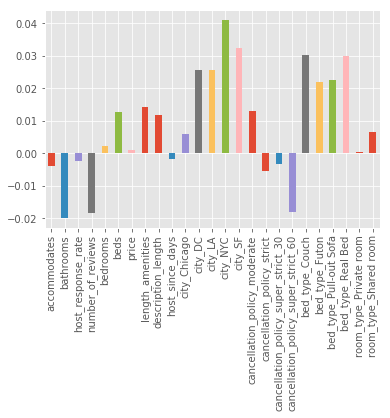

In [25]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

weights = pd.Series(lr_clf.coef_[0], df_logistic_dummy.columns)
weights.plot(kind='bar')
plt.show()

As mentioned before, average review score rating was the sole variable used to classify Superusers for this task, but cancellations are also involved in the true Airbnb designation. 

Of the included variables, number_of_reviews is one of the strongest negatively weighted variables for Superuser. It is highly likely that the more reviews a listing accrues, the greater the chances of people leaving negative reviews that tank the average score below our Superuser threshold. Whether through an off-day with a genuinely bad experience or a hard-to-please customer, simply having more reviews invites the possibility of a lower score because dissatisfied guests are often more likely to post negative reviews than satisfied guests with positive ones.

Both variables for character length about the property, description_length and length_amenities, have mild positive weights. It is possible that properties with lots of amenities available and detailed descriptions about a property's attributes that aren't captured cleanly in the regular amenities checklist (such as proximity to areas of interest) allow guests to make well-informed decisions to their own needs, which would translate to good stays and five-star reviews.

In [26]:
error_y=dict(
            type='data',
            array=np.std(weights,axis=0),
            visible=True
        )
error_y

{'type': 'data', 'array': 0.0163619852067034, 'visible': True}

In [27]:
graph1 = {'x': df_logistic_dummy.columns,
          'y': np.mean(weights,axis=0),
    'error_y':error_y,
       'type': 'bar'}
graph1

{'x': Index(['accommodates', 'bathrooms', 'host_response_rate', 'number_of_reviews',
        'bedrooms', 'beds', 'price', 'length_amenities', 'description_length',
        'host_since_days', 'city_Chicago', 'city_DC', 'city_LA', 'city_NYC',
        'city_SF', 'cancellation_policy_moderate', 'cancellation_policy_strict',
        'cancellation_policy_super_strict_30',
        'cancellation_policy_super_strict_60', 'bed_type_Couch',
        'bed_type_Futon', 'bed_type_Pull-out Sofa', 'bed_type_Real Bed',
        'room_type_Private room', 'room_type_Shared room'],
       dtype='object'),
 'y': 0.008980003301135197,
 'error_y': {'type': 'data', 'array': 0.0163619852067034, 'visible': True},
 'type': 'bar'}

In [28]:
fig = dict()
fig['data'] = [graph1]
fig['layout'] = {'title': 'Logistic Regression Weights, with error bars'}

plotly.offline.iplot(fig)

NameError: name 'plotly' is not defined

### Support Vector Machine Model

### Interpretation of Support Vectors

<i>[10 pts] Look at the chosen support vectors for the classification task. Do these provide any insight into the data? Explain. If you used stochastic gradient descent (and therefore did not explicitly solve for support vectors), try subsampling your data to train the SVC model— then analyze the support vectors from the subsampled dataset.</i>

## Model Comparisons: Advantages, Performance, Efficiency

<i>[10 Points]
* Discuss advantages of each model for each classification task
* Does one type of model offer superior performance over another in terms of prediction accuracy?
    * In terms of training time or efficiency? Explain.</i>